# Session 12: Introduction to Tensor Flow for Deep Learning

------------------------------------------------------
*Machine Learning, Master in Big Data Analytics, 2017-2018*

*Pablo M. Olmos olmos@tsc.uc3m.es*

------------------------------------------------------


Goals for today:
    - Train a multinomial Logistic Regressor with Gradient Descend
    - Train a multinomial Logistic Regressor with Stochastic Gradient Descend
    - Introduce regularization in the two models above. Select the regularization parameter via CV
    
    - Create a Neural Network Classifier with 2 layers
    
This is a personal wrap-up of all the material provided by [Google's Deep Learning course on Udacity](https://www.udacity.com/course/deep-learning--ud730), so all credit goes to them. 

**ALPER KOCABIYIK & GONZALO ALVAREZ**

In [0]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
import numpy as np
import tensorflow as tf
from six.moves import cPickle as pickle
from six.moves import range
from IPython.display import display, Image
import matplotlib.pyplot as plt
# Config the matlotlib backend as plotting inline in IPython
%matplotlib inline


In [2]:
# Lets check what version of tensorflow we have installed. The provided scripts should run with tf 1.0 and above

print(tf.__version__)

1.8.0


## Loading MNIST database

In [3]:
from sklearn.datasets import fetch_mldata
from sklearn.cross_validation import train_test_split
mnist = fetch_mldata('MNIST original')

/usr/local/lib/python3.6/dist-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [0]:
images = mnist.data.astype(np.float32)
labels = mnist.target

train_dataset,test_dataset,train_labels,test_labels = train_test_split(images, labels, test_size=0.33, random_state=42)

train_dataset,valid_dataset,train_labels,valid_labels = train_test_split(train_dataset, train_labels, test_size=0.33, random_state=42)

# Separate a smaller data set for training (20000 images) 
N = 20000

train_dataset = train_dataset[:N,:]
train_labels = train_labels[:N]

Lets visualize some of the images ...

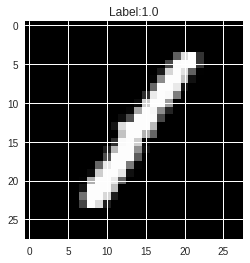

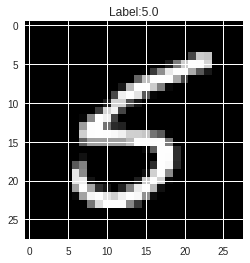

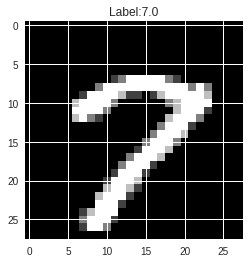

In [5]:
#Generate a random index
num_figs=3
img_size = 28

index=np.random.randint(train_dataset.shape[0], size=num_figs)

for i in range(num_figs):
    plt.figure()
    plt.imshow(train_dataset[index[i],:].reshape([28,28]),cmap=plt.cm.gray)
    plt.title('Label:' + str(train_labels[index[i]]))

### Reformat labels as 1-hot encodings

In [6]:
image_size = 28
num_labels = 10

def reformat(labels):
    # Map 0 to [1.0, 0.0, 0.0 ...], 1 to [0.0, 1.0, 0.0 ...]
    labels = (np.arange(num_labels) == labels[:,None]).astype(np.float32)
    return labels

train_labels = reformat(train_labels)
valid_labels = reformat(valid_labels)
test_labels = reformat(test_labels)
print('Training set', train_dataset.shape, train_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)

Training set (20000, 784) (20000, 10)
Validation set (15477, 784) (15477, 10)
Test set (23100, 784) (23100, 10)


## Lets define and train a Logistir Regressor with tensorflow!!

We're first going to train a multinomial logistic regression using simple gradient descent. 

$$ p(y_i=1|x)=\frac{\text{e}^{(w^T_i x+b_i)}}{\sum_{j=1}^{K} \text{e}^{(w^T_j x+b_j)}}\qquad i=1,\ldots, K$$

where $x\in\mathbb{R}^D$ is the input array vector, $w_i\in\mathbb{R}^D$ for $i=1,\ldots, J$ and $b\in\mathbb{R}^J$ are the weights and biases to be estimated and $y_i$ is the output (one-hot encoded) vector, $i=1,\ldots, J$. Weight matrix $W=[w_1 w_2 \ldots w_J]_{D\times J}$ is chosen to minimize the cross-entropy loss function:

$$ L(W)=-\frac{1}{N}\sum_{n=1}^{N} \sum_{i=1}^{K}  y_i^{n} \log\left(p(y^{n}_i=1|x^n)\right)$$ 

where $(x^n,y^n)$ is the $n$-th data of the training set.


### Computation graphs and Sessions in TF

TensorFlow works like this:

    First you describe the computation that you want to see performed: what the inputs, the variables, and the operations look like. These get created as nodes over a 
    computation graph. This description is all contained within the block below:

    with graph.as_default():
        ...

    Then you can run the operations on this graph as many times as you want by calling session.run(), providing it outputs to fetch from the graph that get returned. This runtime operation is all contained in the block below:

    with tf.Session(graph=graph) as session:
        ...

Let's load all the data into TensorFlow and build the computation graph corresponding to our training

In [7]:
# With gradient descent training, even this much data is prohibitive.
# Subset the training data for faster turnaround.
train_subset = 1000

graph_LR = tf.Graph()

with graph_LR.as_default():
    
    # Input data.
    # Load the training, validation and test data into constants that are
    # attached to the graph.
    tf_train_dataset = tf.constant(train_dataset[:train_subset, :])
    tf_train_labels = tf.constant(train_labels[:train_subset])
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)    

    # Variables.
    # These are the parameters that we are going to be training. The weight
    # matrix will be initialized using random values following a (truncated)
    # normal distribution. The biases get initialized to zero.
    weights = tf.Variable(tf.truncated_normal([image_size * image_size, num_labels]))
    
    biases = tf.Variable(tf.zeros([num_labels]))

    # Training computation.
    # We multiply the inputs with the weight matrix, and add biases. We compute
    # the softmax and cross-entropy (it's one operation in TensorFlow, because
    # it's very common, and it can be optimized). We take the average of this
    # cross-entropy across all training examples: that's our loss.
    logits = tf.matmul(tf_train_dataset, weights) + biases
    
    loss = tf.reduce_mean(
        tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels,logits=logits))
    
    # Optimizer.
    # We are going to find the minimum of this loss using gradient descent.
    # We can either use standard Gradiend Descend (if you uncomment the following line)
    # optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
    
    # or more robust and efficient optimizers  like ADAM (among many others)
    # https://arxiv.org/abs/1412.6980  
    optimizer = tf.train.AdamOptimizer(learning_rate=5e-03).minimize(loss)
    
    # Predictions for the training, validation, and test data.
    # These are not part of training, but merely here so that we can report
    # accuracy figures as we train.
    train_prediction = tf.nn.softmax(logits)
    valid_prediction = tf.nn.softmax(tf.matmul(tf_valid_dataset, weights) + biases)
    test_prediction = tf.nn.softmax(tf.matmul(tf_test_dataset, weights) + biases) 

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See @{tf.nn.softmax_cross_entropy_with_logits_v2}.



In [0]:
def accuracy(predictions, labels):
    return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
              / predictions.shape[0])

In [9]:
# Number of GD steps
num_steps=3000

with tf.Session(graph=graph_LR) as session:
    
    # This is a one-time operation which ensures the parameters get initialized as
    # we described in the graph: random weights for the matrix, zeros for the
    # biases.
    
    tf.global_variables_initializer().run()
    
    print('Initialized')
    
    for step in range(num_steps):
        # Run the computations. We tell .run() that we want to run the optimizer,
        # and get the loss value and the training predictions returned as numpy
        # arrays.
        
        _, l, predictions = session.run([optimizer, loss, train_prediction])
        
        if (step % 500 == 0):
            print('Loss at step %d: %f' % (step, l))
            print('Training accuracy: %.1f%%' % accuracy(
                predictions, train_labels[:train_subset, :]))
            
            # Calling .eval() on valid_prediction is basically like calling run(), but
            # just to get that one numpy array. Note that it recomputes all its graph
            # dependencies.
            
            print('Validation accuracy: %.1f%%' % accuracy(
                valid_prediction.eval(), valid_labels))
            
    print('Test accuracy: %.1f%%' % accuracy(test_prediction.eval(), test_labels))

Initialized
Loss at step 0: 3412.025146
Training accuracy: 11.4%
Validation accuracy: 11.3%
Loss at step 500: 0.612273
Training accuracy: 99.7%
Validation accuracy: 72.5%
Loss at step 1000: 0.000010
Training accuracy: 100.0%
Validation accuracy: 72.6%
Loss at step 1500: 0.000004
Training accuracy: 100.0%
Validation accuracy: 72.6%
Loss at step 2000: 0.000002
Training accuracy: 100.0%
Validation accuracy: 72.6%
Loss at step 2500: 0.000002
Training accuracy: 100.0%
Validation accuracy: 72.6%
Test accuracy: 73.2%


## Let's now switch to stochastic gradient descent training instead, which is much faster.

To allow efficient trainning across large databases, we will perform GD using a small minibatch of data that will be changed everytime.

The graph will be similar, except that instead of holding all the training data into a constant node, we create a Placeholder node which will be fed actual data at every call of session.run().

Btw, if you want to know more about optimization algorithms, [check out this post!](http://ruder.io/optimizing-gradient-descent/).

In [0]:
batch_size = 128

graph_LR_SGD = tf.Graph()

with graph_LR_SGD.as_default():
    
    # Input data.
    # Input data. For the training data, we use a placeholder that will be fed
    # at run time with a training minibatch.
    tf_train_dataset = tf.placeholder(tf.float32,shape=(batch_size, image_size * image_size))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)    

    # Variables.
    weights = tf.Variable(tf.truncated_normal([image_size * image_size, num_labels]))
    biases = tf.Variable(tf.zeros([num_labels]))

    # Loss
    logits = tf.matmul(tf_train_dataset, weights) + biases
    
    loss = tf.reduce_mean(
        tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels,logits=logits))
    
    # Optimizer.
    optimizer = tf.train.AdamOptimizer(learning_rate=5e-03).minimize(loss)
    
    
    # Predictions for the training, validation, and test data.
    train_prediction = tf.nn.softmax(logits)
    valid_prediction = tf.nn.softmax(
        tf.matmul(tf_valid_dataset, weights) + biases)
    test_prediction = tf.nn.softmax(tf.matmul(tf_test_dataset, weights) + biases) 

In [11]:
num_steps = 30001

with tf.Session(graph=graph_LR_SGD) as session:
    
    tf.global_variables_initializer().run()
    print("Initialized")
    for step in range(num_steps):
        
        # Pick an offset within the training data, which has been randomized.
        # Note: we could use better randomization across epochs.
        
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        
        # Generate a minibatch.
        
        batch_data = train_dataset[offset:(offset + batch_size), :]
        batch_labels = train_labels[offset:(offset + batch_size), :]
        
        # Prepare a dictionary telling the session where to feed the minibatch.
        # The key of the dictionary is the placeholder node of the graph to be fed,
        # and the value is the numpy array to feed to it.
        
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
        
       
        _, l, predictions = session.run(
          [optimizer, loss, train_prediction], feed_dict=feed_dict)
        
        if (step % 1000 == 0):
            print("Minibatch loss at step %d: %f" % (step, l))
            print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
            print("Validation accuracy: %.1f%%" % accuracy(
                valid_prediction.eval(), valid_labels))

    print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 3889.312988
Minibatch accuracy: 4.7%
Validation accuracy: 7.6%
Minibatch loss at step 1000: 86.266190
Minibatch accuracy: 85.9%
Validation accuracy: 85.5%
Minibatch loss at step 2000: 36.155056
Minibatch accuracy: 92.2%
Validation accuracy: 86.4%
Minibatch loss at step 3000: 38.847771
Minibatch accuracy: 88.3%
Validation accuracy: 86.2%
Minibatch loss at step 4000: 62.196545
Minibatch accuracy: 89.8%
Validation accuracy: 87.1%
Minibatch loss at step 5000: 16.951870
Minibatch accuracy: 92.2%
Validation accuracy: 86.2%
Minibatch loss at step 6000: 21.395817
Minibatch accuracy: 89.8%
Validation accuracy: 86.7%
Minibatch loss at step 7000: 11.004202
Minibatch accuracy: 91.4%
Validation accuracy: 86.6%
Minibatch loss at step 8000: 1.975862
Minibatch accuracy: 97.7%
Validation accuracy: 87.2%
Minibatch loss at step 9000: 9.015053
Minibatch accuracy: 94.5%
Validation accuracy: 87.1%
Minibatch loss at step 10000: 25.291018
Minibatch accuracy: 93.0%
Validat

## Now, lets introduce regularization via L2 penalization in the cost function


$$ L(W)=-\frac{1}{N}\sum_{n=1}^{N} \sum_{i=1}^{K}  y_i^{n} \log\left(p(y^{n}_i=1|x^n)\right)+\beta||W||_2$$


In [0]:
batch_size = 128
beta=1.0 #Regularization parameter
graph_LR_SGD_REG = tf.Graph()

with graph_LR_SGD_REG.as_default():

    # Input data. For the training data, we use a placeholder that will be fed
    # at run time with a training minibatch.
    tf_train_dataset = tf.placeholder(tf.float32,
                                    shape=(batch_size, image_size * image_size))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)
    
    ## We feed the beta parameter as a placeholder
    tf_beta=tf.placeholder(tf.float32)
  
    # Variables.
    weights = tf.Variable(
        tf.truncated_normal([image_size * image_size, num_labels]))
    biases = tf.Variable(tf.zeros([num_labels]))
  
    # Training computation.
    logits = tf.matmul(tf_train_dataset, weights) + biases
    loss = (tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels,logits=logits))
            +tf_beta*tf.reduce_mean(tf.nn.l2_loss(weights)))
  
    # Optimizer.
    optimizer = tf.train.AdamOptimizer(learning_rate=5e-03).minimize(loss)
  
    # Predictions for the training, validation, and test data.
    train_prediction = tf.nn.softmax(logits)
    valid_prediction = tf.nn.softmax(
    tf.matmul(tf_valid_dataset, weights) + biases)
    test_prediction = tf.nn.softmax(tf.matmul(tf_test_dataset, weights) + biases)

Since we will chosse $\beta$  by CV, we define a function to train de model, with $\beta$ value as input parameter

In [0]:
def train_LR_SGD_REG(mygraph,beta,num_steps):
    
    with tf.Session(graph=mygraph) as session:
        tf.global_variables_initializer().run()
        print("Reg. parameter =%r" %(beta))
        for step in range(num_steps):

            offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
            # Generate a minibatch.
            batch_data = train_dataset[offset:(offset + batch_size), :]
            batch_labels = train_labels[offset:(offset + batch_size), :]
            
            feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels, tf_beta: beta}
            _, l, predictions = session.run(
                [optimizer, loss, train_prediction], feed_dict=feed_dict)
        valid_accuracy,test_accuracy=accuracy(valid_prediction.eval(), valid_labels),accuracy(test_prediction.eval(), test_labels)
    
    return valid_accuracy,test_accuracy

In [14]:
num_steps = 30001
beta=np.logspace(-3, -1, 5) #Regularization parameter
val_performace=np.zeros(beta.shape)
test_performace=np.zeros(beta.shape) 
for i in range(beta.shape[0]):
    val_performace[i], test_performace[i]=train_LR_SGD_REG(graph_LR_SGD_REG,beta[i],num_steps)

Reg. parameter =0.001
Reg. parameter =0.0031622776601683794
Reg. parameter =0.01
Reg. parameter =0.03162277660168379
Reg. parameter =0.1


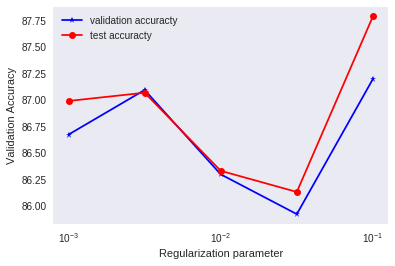

In [15]:
plt.semilogx(beta,val_performace,'b-*', label='validation accuracty')
plt.semilogx(beta,test_performace,'r-o', label='test accuracty')
plt.xlabel('Regularization parameter')
plt.ylabel('Validation Accuracy')
plt.legend(loc=2)
plt.grid()

In [16]:
print ("Test accuracy: %r" %(np.max(test_performace)))

betaCV=beta[np.argmax(val_performace)]

print (betaCV)

Test accuracy: 87.78354978354979
0.1


## Using TF predefined layers

So far, we have defined the NN step by step. First defining the variables, and then the operations with them. In general, it will be faster to use some of the predefined layers provided by the TF package. See the following link for a complete documentation on the [Module: tf.layers](https://www.tensorflow.org/api_docs/python/tf/layers). In particular, check out the module [tf.layers.dense](https://www.tensorflow.org/api_docs/python/tf/layers/dense)

The following link computation graph does exactly the same tasks than the NN we implemented above:

In [0]:
batch_size = 128

graph_LR_SGD_with_layers = tf.Graph()

with graph_LR_SGD_with_layers.as_default():

    # Input data. 
    tf_train_dataset = tf.placeholder(tf.float32,
                                    shape=(batch_size, image_size * image_size))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)
    
    # We feed the beta parameter as a placeholder
    tf_beta=tf.placeholder(tf.float32)
    
    # Regularizer
    regularizer = tf.contrib.layers.l2_regularizer(scale=tf_beta)
    # Weight initializer
    def_init = tf.random_normal_initializer(stddev=0.05)
    
    # We set activation to None, since the non-learity is integrated in the loss function
    
    logits = tf.layers.dense(inputs=tf_train_dataset,units=num_labels,name='Layer_1',
                             reuse=None,activation=None,kernel_regularizer=regularizer)
  
    # Loss
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels,logits=logits))
    l2_loss = tf.losses.get_regularization_loss()
    loss += l2_loss
            
  
    # Optimizer.
    optimizer = tf.train.AdamOptimizer(learning_rate=5e-03).minimize(loss)
  
    # Predictions for the training, validation, and test data.
    train_prediction = tf.nn.softmax(logits)
    
    valid_prediction = tf.layers.dense(inputs=tf_valid_dataset,units=num_labels,reuse=True,
                             activation=tf.nn.softmax,kernel_regularizer=regularizer,name='Layer_1')
    
    test_prediction = tf.layers.dense(inputs=tf_test_dataset,units=num_labels,reuse=True,
                             activation=tf.nn.softmax,kernel_regularizer=regularizer,name='Layer_1')

In [18]:
num_steps = 30000
beta=np.logspace(-3, -1, 5) #Regularization parameter
val_performace=np.zeros(beta.shape)
test_performace=np.zeros(beta.shape) 
for i in range(beta.shape[0]):
    val_performace[i], test_performace[i]=train_LR_SGD_REG(graph_LR_SGD_with_layers,beta[i],num_steps)

Reg. parameter =0.001
Reg. parameter =0.0031622776601683794
Reg. parameter =0.01
Reg. parameter =0.03162277660168379
Reg. parameter =0.1


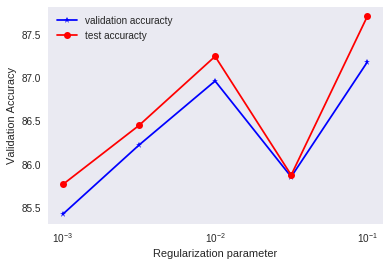

In [19]:
plt.semilogx(beta,val_performace,'b-*', label='validation accuracty')
plt.semilogx(beta,test_performace,'r-o', label='test accuracty')
plt.xlabel('Regularization parameter')
plt.ylabel('Validation Accuracy')
plt.legend(loc=2)
plt.grid()

In [20]:
print ("Test accuracy: %r" %(np.max(test_performace)))

betaCV=beta[np.argmax(val_performace)]

print (betaCV)

Test accuracy: 87.70995670995671
0.1


## A 2 layer NN with dropout regularization

[Dropout](http://jmlr.org/papers/v15/srivastava14a.html) is a simple and powerful regularization technique for neural networks and deep learning models.

Take a look to the following video for a quick explanation:

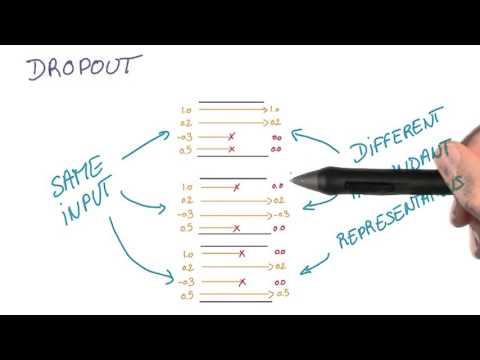

In [21]:
from IPython.display import YouTubeVideo

YouTubeVideo('NhZVe50QwPM')   

In [0]:
batch_size = 64

hidden_units = 500

hidden_prob = 0.6

graph_LR_SGD_with_2_layers = tf.Graph()

with graph_LR_SGD_with_2_layers.as_default():

    # Input data. 
    tf_train_dataset = tf.placeholder(tf.float32,
                                    shape=(batch_size, image_size * image_size))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)
    
    # We feed the beta parameter as a placeholder
    tf_beta=tf.placeholder(tf.float32)
   
    # Regularizer
    regularizer = tf.contrib.layers.l2_regularizer(scale=tf_beta)
    # Weight initializer
    def_init = tf.random_normal_initializer(stddev=0.05)
    
    # We set activation to hiperbolic tangent
    
    hidden_1 = tf.layers.dense(inputs=tf_train_dataset,units=hidden_units,name='Layer_1',
                             reuse=None,activation=tf.nn.tanh,kernel_regularizer=regularizer)
    
    # Dropout with probability hiddepn_prob
    
    hidden_1_drop =tf.nn.dropout(hidden_1,hidden_prob)
    
    # We set activation to None, since the non-learity is integrated in the loss function
    
    logits = tf.layers.dense(inputs=hidden_1_drop,units=num_labels,name='Layer_2',
                             reuse=None,activation=None,kernel_regularizer=regularizer)
    
    # Loss
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels,logits=logits))
    l2_loss = tf.losses.get_regularization_loss()
    loss += l2_loss
            
  
    # Optimizer.
    optimizer = tf.train.AdamOptimizer(learning_rate=5e-03).minimize(loss)
  
    # Predictions for the training, validation, and test data.
    train_prediction = tf.nn.softmax(logits)

    hidden_1_val = tf.layers.dense(inputs=tf_valid_dataset,units=hidden_units,name='Layer_1',
                             reuse=True,activation=tf.nn.tanh,kernel_regularizer=regularizer)
    
    hidden_1_drop_val =tf.nn.dropout(hidden_1_val,1.0)
    
    valid_prediction = tf.layers.dense(inputs=hidden_1_drop_val,units=num_labels,name='Layer_2',
                             reuse=True,activation=tf.nn.softmax,kernel_regularizer=regularizer)
    
    
    hidden_1_test = tf.layers.dense(inputs=tf_test_dataset,units=hidden_units,name='Layer_1',
                             reuse=True,activation=tf.nn.tanh,kernel_regularizer=regularizer)
    hidden_1_drop_test =tf.nn.dropout(hidden_1_test,1.0)
    
    test_prediction = tf.layers.dense(inputs=hidden_1_drop_test,units=num_labels,name='Layer_2',
                             reuse=True,activation=tf.nn.softmax,kernel_regularizer=regularizer)

### Lets check the hability of dropout to regularize by canceling the L2-norm regularization

Compute test and validation performance for hidden_prob = 1.0

In [23]:
num_steps = 30000

val_performace, test_performace=train_LR_SGD_REG(graph_LR_SGD_with_2_layers,0.0,num_steps)

print(val_performace, test_performace)

Reg. parameter =0.0


KeyboardInterrupt: ignored

And now for hidden_prob = 0.6

In [28]:
val_performace, test_performace=train_LR_SGD_REG(graph_LR_SGD_with_2_layers,0.0,num_steps)

print(val_performace, test_performace)

Reg. parameter =0.0
85.875815726562 86.65800865800865


## Problem 1

1) Analize the performance of the network for different values of the number of hidden units

2) Modify the computation graph of the 2-layer NN to extract the model parameters (weight and bias of the different dense layers). Check the function [tf.global_variables](https://www.tensorflow.org/api_docs/python/tf/global_variables). **How many parameters the network has?**

3) Represent the hidden layer as an image for different images

4) Implement a 3-layer NN of small size (otherwise is too heavy to train)

** This problem is part of the last assigment of the course!**

**1) Analize the performance of the network for different values of the number of hidden units**

In [30]:
# 1) Analize the performance of the network for different values of the number of hidden units

batch_size = 64
hidden_prob = 0.6

for hidden_units in [100,500,1000]:
  graph_LR_SGD_with_3_layers = tf.Graph()

  with graph_LR_SGD_with_2_layers.as_default():

      # Input data. 
      tf_train_dataset = tf.placeholder(tf.float32,
                                      shape=(batch_size, image_size * image_size))
      tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
      tf_valid_dataset = tf.constant(valid_dataset)
      tf_test_dataset = tf.constant(test_dataset)

      # We feed the beta parameter as a placeholder
      tf_beta=tf.placeholder(tf.float32)

      # Regularizer
      regularizer = tf.contrib.layers.l2_regularizer(scale=tf_beta)
      # Weight initializer
      def_init = tf.random_normal_initializer(stddev=0.05)

      # We set activation to hiperbolic tangent

      hidden_1 = tf.layers.dense(inputs=tf_train_dataset,units=hidden_units,name='Layer_1',
                               reuse=None,activation=tf.nn.tanh,kernel_regularizer=regularizer)

      # Dropout with probability hiddepn_prob

      hidden_1_drop =tf.nn.dropout(hidden_1,hidden_prob)

      # We set activation to None, since the non-learity is integrated in the loss function

      logits = tf.layers.dense(inputs=hidden_1_drop,units=num_labels,name='Layer_2',
                               reuse=None,activation=None,kernel_regularizer=regularizer)

      # Loss
      loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels,logits=logits))
      l2_loss = tf.losses.get_regularization_loss()
      loss += l2_loss


      # Optimizer.
      optimizer = tf.train.AdamOptimizer(learning_rate=5e-03).minimize(loss)

      # Predictions for the training, validation, and test data.
      train_prediction = tf.nn.softmax(logits)

      hidden_1_val = tf.layers.dense(inputs=tf_valid_dataset,units=hidden_units,name='Layer_1',
                               reuse=True,activation=tf.nn.tanh,kernel_regularizer=regularizer)

      hidden_1_drop_val =tf.nn.dropout(hidden_1_val,1.0)

      valid_prediction = tf.layers.dense(inputs=hidden_1_drop_val,units=num_labels,name='Layer_2',
                               reuse=True,activation=tf.nn.softmax,kernel_regularizer=regularizer)


      hidden_1_test = tf.layers.dense(inputs=tf_test_dataset,units=hidden_units,name='Layer_1',
                               reuse=True,activation=tf.nn.tanh,kernel_regularizer=regularizer)
      hidden_1_drop_test =tf.nn.dropout(hidden_1_test,1.0)

      test_prediction = tf.layers.dense(inputs=hidden_1_drop_test,units=num_labels,name='Layer_2',
                               reuse=True,activation=tf.nn.softmax,kernel_regularizer=regularizer)


# Running the net 

  num_steps = 30000

  val_performace, test_performace=train_LR_SGD_REG(graph_LR_SGD_with_2_layers,0.0,num_steps)

  print("\n#hidden units: ",hidden_units,'\nvalidation accuracy: ',val_performace,'\ntest accuracy: ', test_performace)

Reg. parameter =0.0

#hidden units:  100 
validation accuracy:  86.02442333785618 
test accuracy:  86.5108225108225
Reg. parameter =0.0

#hidden units:  500 
validation accuracy:  86.30225495897137 
test accuracy:  86.9047619047619
Reg. parameter =0.0

#hidden units:  1000 
validation accuracy:  86.56716417910448 
test accuracy:  87.22510822510823


**2) Modify the computation graph of the 2-layer NN to extract the model parameters (weight and bias of the different dense layers). Check the function tf.global_variables. How many parameters the network has?**

In [20]:
# 2) Modify the computation graph of the 2-layer NN to extract the model parameters (weight and bias of the different dense layers). 
#Check the function tf.global_variables. How many parameters the network has?

batch_size = 64
hidden_prob = 0.6
hidden_units = 500

if True:
  
  graph_LR_SGD_with_2_layers = tf.Graph()

  with graph_LR_SGD_with_2_layers.as_default():

      # Input data. 
      tf_train_dataset = tf.placeholder(tf.float32,
                                      shape=(batch_size, image_size * image_size))
      tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
      tf_valid_dataset = tf.constant(valid_dataset)
      tf_test_dataset = tf.constant(test_dataset)

      # We feed the beta parameter as a placeholder
      tf_beta=tf.placeholder(tf.float32)

      # Regularizer
      regularizer = tf.contrib.layers.l2_regularizer(scale=tf_beta)
      # Weight initializer
      def_init = tf.random_normal_initializer(stddev=0.05)

      # We set activation to hiperbolic tangent

      hidden_1 = tf.layers.dense(inputs=tf_train_dataset,units=hidden_units,name='Layer_1',
                               reuse=None,activation=tf.nn.tanh,kernel_regularizer=regularizer)

      # Dropout with probability hiddepn_prob

      hidden_1_drop =tf.nn.dropout(hidden_1,hidden_prob)

      # We set activation to None, since the non-learity is integrated in the loss function

      logits = tf.layers.dense(inputs=hidden_1_drop,units=num_labels,name='Layer_2',
                               reuse=None,activation=None,kernel_regularizer=regularizer)
      

      # Loss
      loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels,logits=logits))
      l2_loss = tf.losses.get_regularization_loss()
      loss += l2_loss


      # Optimizer.
      optimizer = tf.train.AdamOptimizer(learning_rate=5e-03).minimize(loss)

      # Predictions for the training, validation, and test data.
      train_prediction = tf.nn.softmax(logits)

      hidden_1_val = tf.layers.dense(inputs=tf_valid_dataset,units=hidden_units,name='Layer_1',
                               reuse=True,activation=tf.nn.tanh,kernel_regularizer=regularizer)

      hidden_1_drop_val =tf.nn.dropout(hidden_1_val,1.0)

      valid_prediction = tf.layers.dense(inputs=hidden_1_drop_val,units=num_labels,name='Layer_2',
                               reuse=True,activation=tf.nn.softmax,kernel_regularizer=regularizer)


      hidden_1_test = tf.layers.dense(inputs=tf_test_dataset,units=hidden_units,name='Layer_1',
                               reuse=True,activation=tf.nn.tanh,kernel_regularizer=regularizer)
      hidden_1_drop_test =tf.nn.dropout(hidden_1_test,1.0)

      test_prediction = tf.layers.dense(inputs=hidden_1_drop_test,units=num_labels,name='Layer_2',
                               reuse=True,activation=tf.nn.softmax,kernel_regularizer=regularizer)
      
      # Global Variales - Proplem 2)
      global_vars = tf.global_variables()
      print (global_vars)
      print('\nNumber of global varibles: %d. Each layer has %d parameters.\n' %(len(global_vars), len(global_vars)/2))
      for var in global_vars:
        name = var.name.split(':')[0].split('/')
        layer = name[0]
        if(layer.split('_')[0] == "Layer"):
          print(layer, name[1:])
        else:
          print(name)

[<tf.Variable 'Layer_1/kernel:0' shape=(784, 500) dtype=float32_ref>, <tf.Variable 'Layer_1/bias:0' shape=(500,) dtype=float32_ref>, <tf.Variable 'Layer_2/kernel:0' shape=(500, 10) dtype=float32_ref>, <tf.Variable 'Layer_2/bias:0' shape=(10,) dtype=float32_ref>, <tf.Variable 'beta1_power:0' shape=() dtype=float32_ref>, <tf.Variable 'beta2_power:0' shape=() dtype=float32_ref>, <tf.Variable 'Layer_1/kernel/Adam:0' shape=(784, 500) dtype=float32_ref>, <tf.Variable 'Layer_1/kernel/Adam_1:0' shape=(784, 500) dtype=float32_ref>, <tf.Variable 'Layer_1/bias/Adam:0' shape=(500,) dtype=float32_ref>, <tf.Variable 'Layer_1/bias/Adam_1:0' shape=(500,) dtype=float32_ref>, <tf.Variable 'Layer_2/kernel/Adam:0' shape=(500, 10) dtype=float32_ref>, <tf.Variable 'Layer_2/kernel/Adam_1:0' shape=(500, 10) dtype=float32_ref>, <tf.Variable 'Layer_2/bias/Adam:0' shape=(10,) dtype=float32_ref>, <tf.Variable 'Layer_2/bias/Adam_1:0' shape=(10,) dtype=float32_ref>]

Number of global varibles: 14. Each layer has 7 

**3) Represent the hidden layer as an image for different images**

In [25]:
# 3) Represent the hidden layer as an image for different images

def train_LR_SGD_REG_mod(mygraph,beta,num_steps):
    
    with tf.Session(graph=mygraph) as session:
        tf.global_variables_initializer().run()
        print("Reg. parameter =%r" %(beta))
        for step in range(num_steps):

            offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
            # Generate a minibatch.
            batch_data = train_dataset[offset:(offset + batch_size), :]
            batch_labels = train_labels[offset:(offset + batch_size), :]
            
            feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels, tf_beta: beta}
            _, l, predictions = session.run(
                [optimizer, loss, train_prediction], feed_dict=feed_dict)
        valid_accuracy,test_accuracy=accuracy(valid_prediction.eval(), valid_labels),accuracy(test_prediction.eval(), test_labels)
        
        Lay=session.run([tf.global_variables(scope='Layer_1/kernel:0'),tf.global_variables(scope='Layer_1/bias:0'),
                                      tf.global_variables(scope='Layer_2/kernel:0'),tf.global_variables(scope='Layer_2/bias:0')], feed_dict=feed_dict)
    
    return valid_accuracy,test_accuracy,Lay

# Running the net  

num_steps = 30000

val_performace, test_performace, Lay= train_LR_SGD_REG_mod(graph_LR_SGD_with_2_layers,0.0,num_steps)

print("\n hidden units: ",hidden_units,'val acc: ',val_performace,'test acc: ', test_performace)


Reg. parameter =0.0

 hidden units:  500 val acc:  85.36538088776895 test acc:  85.83549783549783


Text(0.5,1,'Label weight')

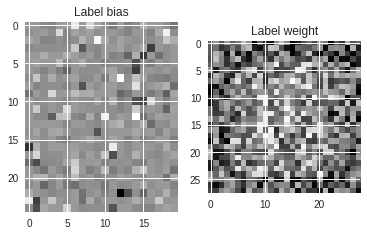

In [59]:
plt.subplot(1,2,1)
plt.imshow(Lay[1][0].reshape([25, 20]),cmap=plt.cm.gray)
plt.title('Label bias')
plt.subplot(1,2,2)
plt.imshow(Lay[0][0][:,0].reshape([28,28]),cmap=plt.cm.gray)
plt.title('Label weight')

**4) Implement a 3-layer NN of small size (otherwise is too heavy to train)**

In [40]:
# 4) Implement a 3-layer NN of small size (otherwise is too heavy to train)

batch_size = 64
hidden_prob = 0.6
hidden_unit1=40
hidden_unit2=80
  
graph_LR_SGD_with_3_layers = tf.Graph()

with graph_LR_SGD_with_3_layers.as_default():

    # Input data. 
    tf_train_dataset = tf.placeholder(tf.float32,
                                    shape=(batch_size, image_size * image_size))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)

    # We feed the beta parameter as a placeholder
    tf_beta=tf.placeholder(tf.float32)

    # Regularizer
    regularizer = tf.contrib.layers.l2_regularizer(scale=tf_beta)
    # Weight initializer
    def_init = tf.random_normal_initializer(stddev=0.05)

    # We set activation to hiperbolic tangent

    hidden_1 = tf.layers.dense(inputs=tf_train_dataset,units=hidden_unit1,name='Layer_1',
                             reuse=None,activation=tf.nn.tanh,kernel_regularizer=regularizer)

    # Dropout with probability hiddepn_prob

    hidden_1_drop =tf.nn.dropout(hidden_1,hidden_prob)

    # hidden 2
    hidden_2 = tf.layers.dense(inputs=hidden_1_drop,units=hidden_unit2,name='Layer_2',
                             reuse=None,activation=tf.nn.tanh,kernel_regularizer=regularizer)

    # Dropout with probability hiddepn_prob

    hidden_2_drop =tf.nn.dropout(hidden_2,hidden_prob)      


    # We set activation to None, since the non-learity is integrated in the loss function

    logits = tf.layers.dense(inputs=hidden_2_drop,units=num_labels,name='Layer_3',
                             reuse=None,activation=None,kernel_regularizer=regularizer)


    # Loss
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels,logits=logits))
    l2_loss = tf.losses.get_regularization_loss()
    loss += l2_loss


    # Optimizer.
    optimizer = tf.train.AdamOptimizer(learning_rate=5e-03).minimize(loss)

    # Predictions for the training, validation, and test data.
    train_prediction = tf.nn.softmax(logits)

    hidden_1_val = tf.layers.dense(inputs=tf_valid_dataset,units=hidden_unit1,name='Layer_1',
                             reuse=True,activation=tf.nn.tanh,kernel_regularizer=regularizer)

    hidden_1_drop_val =tf.nn.dropout(hidden_1_val,1.0)

    hidden_2_val = tf.layers.dense(inputs=hidden_1_drop_val,units=hidden_unit2,name='Layer_2',
                             reuse=True,activation=tf.nn.tanh,kernel_regularizer=regularizer)

    hidden_2_drop_val =tf.nn.dropout(hidden_2_val,1.0)      

    valid_prediction = tf.layers.dense(inputs=hidden_2_drop_val,units=num_labels,name='Layer_3',
                             reuse=True,activation=tf.nn.softmax,kernel_regularizer=regularizer)


    hidden_1_test = tf.layers.dense(inputs=tf_test_dataset,units=hidden_unit1,name='Layer_1',
                             reuse=True,activation=tf.nn.tanh,kernel_regularizer=regularizer)
    hidden_1_drop_test =tf.nn.dropout(hidden_1_test,1.0)

    hidden_2_test = tf.layers.dense(inputs=hidden_1_drop_test,units=hidden_unit2,name='Layer_2',
                             reuse=True,activation=tf.nn.tanh,kernel_regularizer=regularizer)
    hidden_2_drop_test =tf.nn.dropout(hidden_2_test,1.0)      


    test_prediction = tf.layers.dense(inputs=hidden_2_drop_test,units=num_labels,name='Layer_3',
                             reuse=True,activation=tf.nn.softmax,kernel_regularizer=regularizer)


# Running the net 

num_steps = 30000

val_performace, test_performace, L =train_LR_SGD_REG(graph_LR_SGD_with_3_layers,0.0,num_steps)

print("\n#hidden units: ",hidden_units,'\nvalidation accuracy: ',val_performace,'\ntest accuracy: ', test_performace)

Reg. parameter =0.0

#hidden units:  500 
validation accuracy:  78.65865477805777 
test accuracy:  78.42857142857143
